# Correlation Functions

A correlation function is a measure of order in a system. It's main purpose is to determine the spatial relationship between a single atom or group of atoms to other surrounding atoms or groups of atoms.

To understand the expected output of a correlation function calculation, it is easiest to start with a 1D example.

In scenario 1 below, liquid crystal monomers are stacked in a perfect column. The distance, d, between the center of mass of each head group (head group atoms are highlighted black) is exactly the same in all cases. The associated z-direction (the z-axis runs in the same direction that the monomers stack) correlation function shows equally spaced, equally intense, sharp spikes located at d, 2d, 3d ...

<table><tr>
<td> <img src="images/ordered_monomers_stacked.png" style="width: 300px;" caption> <td>
<td> <img src="images/ordered_correlation_function.png" style="width: 400px;"> <td>
</tr></table>

In the more realistic scenario 2, shown below, the liquid crystal monomers are still stacked in a column, but the head groups are far less ordered. The peaks of the correlation function broaden in response to this disorder, but their maxima are still located at about the same place as scenario 1. The amplitudes of the maxima, however, decays exponentially. The exponent describing this decay is related to the **correlation length** of the system which is a measure of the distance at which two particle positions are no longer correlated. 

<table><tr>
<td> <img src="images/disordered_monomers_stacked.png" style="width: 300px;" caption> <td>
<td> <img src="images/disordered_correlation_function.png" style="width: 400px;"> <td>
</tr></table>

Now, let's see how to plot a correlation function from a molecular dyanamics trajectory using the classes and functions that are a part of the python script *correlation_function.py* located in the LLC_Membranes repository in LLC_Membranes/analysis/correlation_function.py.

For more detail, see the [Documentation](https://llc-membranes.readthedocs.io/en/latest/correlation.html) for this script!

In [8]:
# Import necessary modules
from LLC_Membranes.analysis import correlation_function

In [13]:
# Define path where trajectory files are located, and the names of the .gro and trajectory files in that directory

path = "/home/jetr9379/Programs/Molecules/Molecule_X1"
gro = 'berendsen.gro'
traj = 'PR.xtc'

In [15]:
# Start by initializing the correlation function with the class 'Correlation'

atoms = ['C', 'C1', 'C2', 'C3', 'C4', 'C5']  # we will calculated the center of mass of these atoms
residue = 'R1'  # name of residue to which atoms belong (the name that appears in the second column of the .gro file)
bins = [100, 100, 100]  # The unit cell will be histogrammed. Specify the number of bins in the x, y and z directions.
 
g = correlation_function.Correlation('%s/%s' %(path, gro), trajectory='%s/%s' %(path, traj), atoms=atoms, res=residue, bins=bins)

Trajectory loaded
Transforming coordinates from monoclinic to cubic unit cell


At this point, we have processed the trajectory so that it is in the correct format for calculating the 3d correlation function. Two main steps just took place:
1. We narrowed the trajectory down to only the atoms we are interested in. If this was a group of atoms, then the center of mass of each group was also calculated.
2. We converted the unit cell to a cube. We can't easily apply a discrete fourier transform to a hexagonal unit cell, so the \__init__ function transforms the coordinates into a cubic cell. This transformation will need to be reversed later.

In [16]:
# Now perform the calculation

g.calculate_correlation_function()  # that's it

100%|██████████| 218/218 [00:05<00:00, 39.93Frames/s]


Now we have a 3D correlation function which is stored in an array that can be accessed by calling the attribute *correlation3d*. Each dimesion of it's shape should be equal to n - 1 of the bin dimensions.

In [17]:
print(g.correlation3d.shape)

(99, 99, 99)


The 3D correlation function has a ton of information, but it's difficult to visualize and extract meaningful conclusions from it. Instead, we can plot 1D and 2D slices of it. 

Currently, only 1D slices are supported. More slices can be added if necessary in the future.

Let's slice the correlation function straight up the z-axis.

In [21]:
axis = 2  # the axis along which to slice. x = 0, y = 1, z = 2

g.make_slice(axis)

/home/jetr9379/Research/LLC_Membranes/LLC_Membranes/analysis/correlation_function.py:266: RuntimeWarning: invalid value encountered in true_divide
  self.slice = g / g.mean()


We ran into an error! (If you didn't, which is possible, just continue to follow along) The error stems from the fact that the center of mass of a given head group is not directly stacked on top of any other head group. The correlation function is 0 at all points, so we run into a divided by zero error. Sure enough, printing the slice will show a bunch of NaNs (not a number).  

In [22]:
print(g.slice)

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]


In the actual LLC membrane system, the head groups are not single points that interact. They are clouds of atoms and electrons whose center of mass does not need to be situated directly above another in order to interact or be considered stacked. In fact, pi-stacking is most stable when phenyl rings are slightly offset from one another on the xy plane. 

To overcome the issue, we can define a radius, R. Any center of mass that is within this radius, on the xy plane, can be counted as a part of the 1D correlation function.

<img src="images/head_group_labeled.png" style="width: 300px;">

In [23]:
r = 0.225  # approximately the van-der-waals radius of benzene
g.make_slice(axis, radius=r)

No error!

No handles with labels found to put in legend.


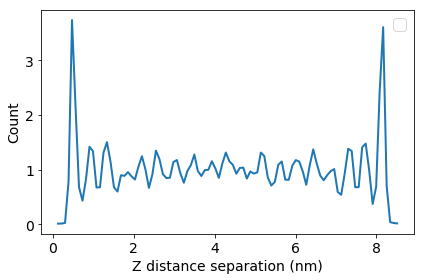

In [26]:
g.plot_slice(2)

We have now plotted a correlation function. But you'll notice that it appears roughly symmetric. That is because we are working with a periodic system. A particle situated at the origin feels about the same amount of correlation from a particle 1 nm above it as it does 1 nm below it. Therefore, we can safely cut off the correlation function halfway without losing any information.

No handles with labels found to put in legend.


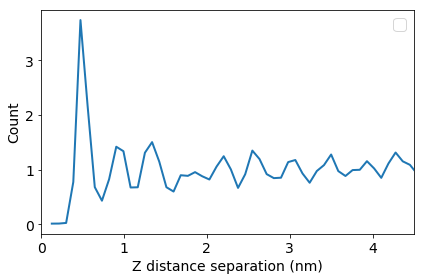

In [27]:
limits = ([0, 4.5], [])  # Plot between 0 and 4.5 on the x-axis. Do not impose any limits on the y-axis (i.e. let matplotlib choose)
g.plot_slice(2, limits=limits)